In [1]:
%load_ext autoreload
%autoreload 2

------------------------------

## Config

In [2]:
import sys

In [3]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

In [4]:
from Util import to_log2_tpm
from Util import long_header

----------------------------

# Create Boxplots: **RNA Stability** (RS)

This mean we analyze the **ratios** between:
- pA RNA **(Steady State RNA)**
- Pol II RIP **(Nascent RNA)**

previously computed and defined as **RNA stability**

This Notebook is used to generate the following **Box Plots**:
- **Figure1**: *Heterochromatic repeats have reduced RNA Pol II occupancy, Transcription Efficiency and RNA stability.*
    - WT - <del>**Figure1-D_stranded**</del>  <font color='red'> **Figure1-F_stranded** </font>
- **Figure2**: *Contribution of distinct pathways to heterochromatic silencing*
    - WT & clr4Δ - <del>**Figure2-C_stranded**</del>  <font color='red'> **Figure2-E_stranded** </font>
- **Figure3**: *RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants*
    - Mutant group 1 - **Figure3-E_stranded**
    - Mutant group 2 - **Figure3-F_stranded**

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [6]:
from viz_strands import prepare_4cat_data, multi_4cat_box_plot, my_multi_4cat_box_plot ## 4-category

-------------

### Data: **rna_stability.csv**

In [7]:
#ratios_dir

In [8]:
#rs_file=os.path.join(in_dir, 'rna_stability.csv')
rs_file=os.path.join(ratios_dir, 'rna_stability.csv')
rs_file

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/rna_stability.csv'

- Import **RNA Stability** (RS) matrix: `rna_stability.csv`

In [9]:
df = pd.read_csv(rs_file, sep='\t')
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,0.659923,0.523778,0.272456,0.265005,0.405359,0.455835,0.385234,0.732856,1.556545,0.355711,0.138715,1.105847,0.612064,0.293368
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1.245972,0.174040,0.893177,0.529501,0.528688,0.495048,0.972946,0.891789,0.218474,2.305563,0.207932,2.012500,0.251523,0.213384
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,2.846018,9.507199,6.065400,1.695289,2.261381,0.240024,0.085662,4.142059,4.926130,1.751570,3.769876,1.529768,2.079317,8.761658
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.shape

(5159, 20)

- Get **sample columns** for filtering `NA`s properly:

In [11]:
init_sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]

In [12]:
# Check if RS ratio is not well defined for any mutants. All NaNs
df = df.dropna(axis=1, how='all')

In [13]:
sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]
len(sample_cols)
#sample_cols

14

In [14]:
print('Ignoring samples: {} RS ratio is not well defined!'.format(set(init_sample_cols).difference(sample_cols)))

Ignoring samples: set() RS ratio is not well defined!


In [15]:
#df[df['gene_id'].isin(non_degraded)][[xx for xx in df.columns if ('80' in xx) | (xx == 'gene_id') | (xx == 'category')]]

#### <font color='red'> Deal with **NAs**: *Drop* or *fill with zeros?* </font>
- <font color='red'> `NaN's` originated from **division by zero**: drop `NaN's` </font>

In [16]:
# (NOT USED)
#df = df.fillna(0) # undesired off-target effects to other columns (e.g. `gene_name`)
#df = df.fillna({kk:0 for kk in sample_cols})

# drop row (axis - 0) if it finds ANY `na`, becareful when adding new columns!
# => why not fillna(0) like before, in `GXP_BoxPlots.ipynb`?
df = df.dropna(subset = sample_cols) 
#df = df.dropna(0)

In [17]:
df.shape

(5049, 20)

In [18]:
#df[df[sample_cols].isnull().any(1)]

In [19]:
# no surprises!
# => there should not be NAs in sample columns (with counts)
assert not df[sample_cols].isnull().values.any()

- **Log-transform** and filter for **Heterochromatic** and **Protein coding** (mRNA) genes

In [20]:
# log transformed `ratios` will be used to visualize boxplots
# => compute log(x), there should be no issues zeros due to ratio defined as (1 + x) / (1 + y)
#df = to_log2_tpm(df, gene_id_col='gene_id')  # default shift=1
df = to_log2_tpm(df, gene_id_col='gene_id', shift=0)  # parastou used this, default shift=1

# Keep only Heterochromatic genes and  protein coding genes (need to change for gff_v2)
#df = df[(df['category'] == 'repeat') | (df['type'] == 'gene')]
df = df[(df['bio_type'] == 'mRNA') | (df['category'] == 'repeat')]
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,-0.599630,-0.932974,-1.875904,-1.915906,-1.302727,-1.133416,-1.376194,-0.448398,0.638348,-1.491223,-2.849807,0.145151,-0.708245,-1.769217
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,0.317272,-2.522507,-0.162982,-0.917295,-0.919510,-1.014360,-0.039568,-0.165225,-2.194469,1.205119,-2.265818,1.008988,-1.991237,-2.228474
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1.508945,3.249020,2.600603,0.761531,1.177204,-2.058752,-3.545198,2.050348,2.300455,0.808649,1.914517,0.613313,1.056110,3.131204
5,FP565355_region_18009..20128,NaN,2120,region,repeat,region,-1.011302,-2.522507,-1.653028,-2.076217,-1.485159,-1.101683,-1.565510,-1.897407,-0.775237,-2.854099,-2.636375,-1.151358,-3.005726,-0.502395
7,FP565355_region_3260..3394,NaN,135,region,repeat,region,0.317272,-2.522507,-0.162982,-0.917295,-0.919510,-1.014360,-0.039568,-0.165225,-2.194469,1.205119,-2.265818,1.008988,-1.991237,-2.228474


In [21]:
df.shape

(5049, 20)

In [22]:
#df[df['gene_id'].isin(non_degraded)]

In [23]:
assert not df[sample_cols].isnull().values.any()

----

## WT - <del>**Figure1-D_stranded**</del>  <font color='red'> **Figure1-F_stranded** </font>

- **Figure 1**. Heterochromatic repeats have reduced RNA Pol II occupancy, Transcription Efficiency and RNA stability.
    - **(D)** Box plot showing RNA stability (pA RNA / Pol II RIP) of indicated genes in wild type cells. Average of at least two independent samples is shown. 

In [24]:
fig_dir = os.path.join(plots_dir, 'Figure1')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure1/Figure1-F_stranded.png


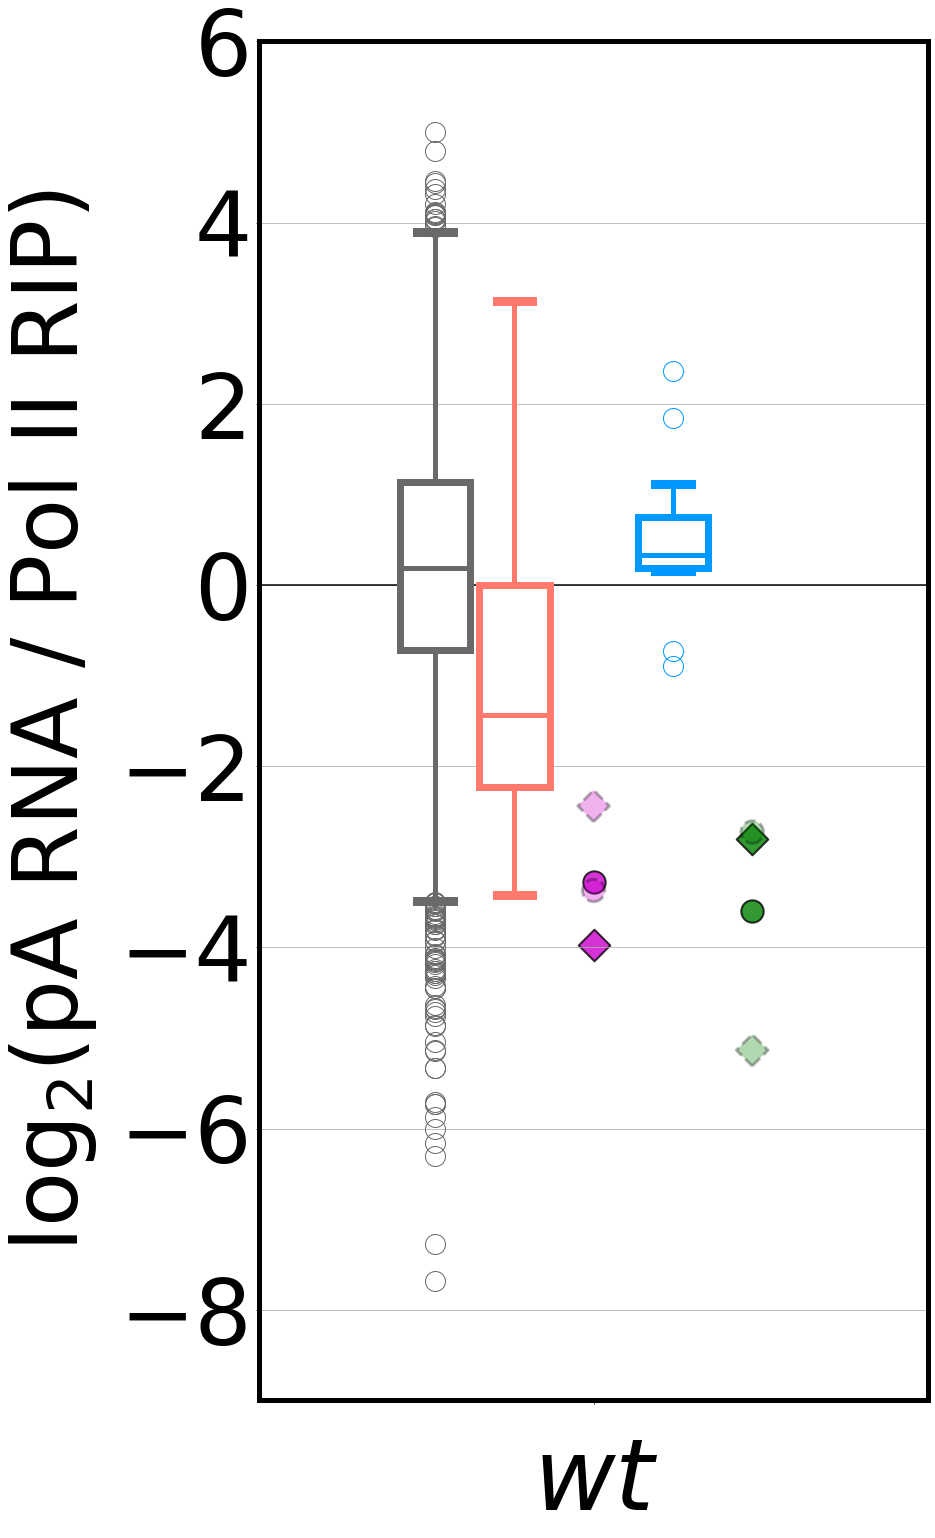

In [25]:
# data and labels
samples = ['WT']
x_labels = ['wt']
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure1-D_stranded.png')
#out_path = os.path.join(fig_dir, 'Figure1-D_stranded.png')
out_path = os.path.join(fig_dir, 'Figure1-F_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels, 
                    out_path,
                    figsize=(12, 25),
                    dist=1, 
                    y_label='$\mathrm{log_2(pA\ RNA\ /\ Pol\ II\ RIP)}$',
                    y_lim=(-9, 6), 
                    widths=.8,
                    hlines=[(0,'black')],
                    xlable_size=100, ylable_size=90, 
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

--------------------

### WT & clr4Δ - <del>**Figure2-C_stranded**</del>  <font color='red'> **Figure2-E_stranded** </font>

- **Figure 2**: Contribution of distinct pathways to heterochromatic silencing 
    - **(C)** Box plot showing RNA stability (pA RNA / Pol II RIP) in wild type and clr4Δ cells. Average of at least two independent samples is shown for all figures. 

In [26]:
fig_dir = os.path.join(plots_dir, 'Figure2')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure2/Figure2-E_stranded.png


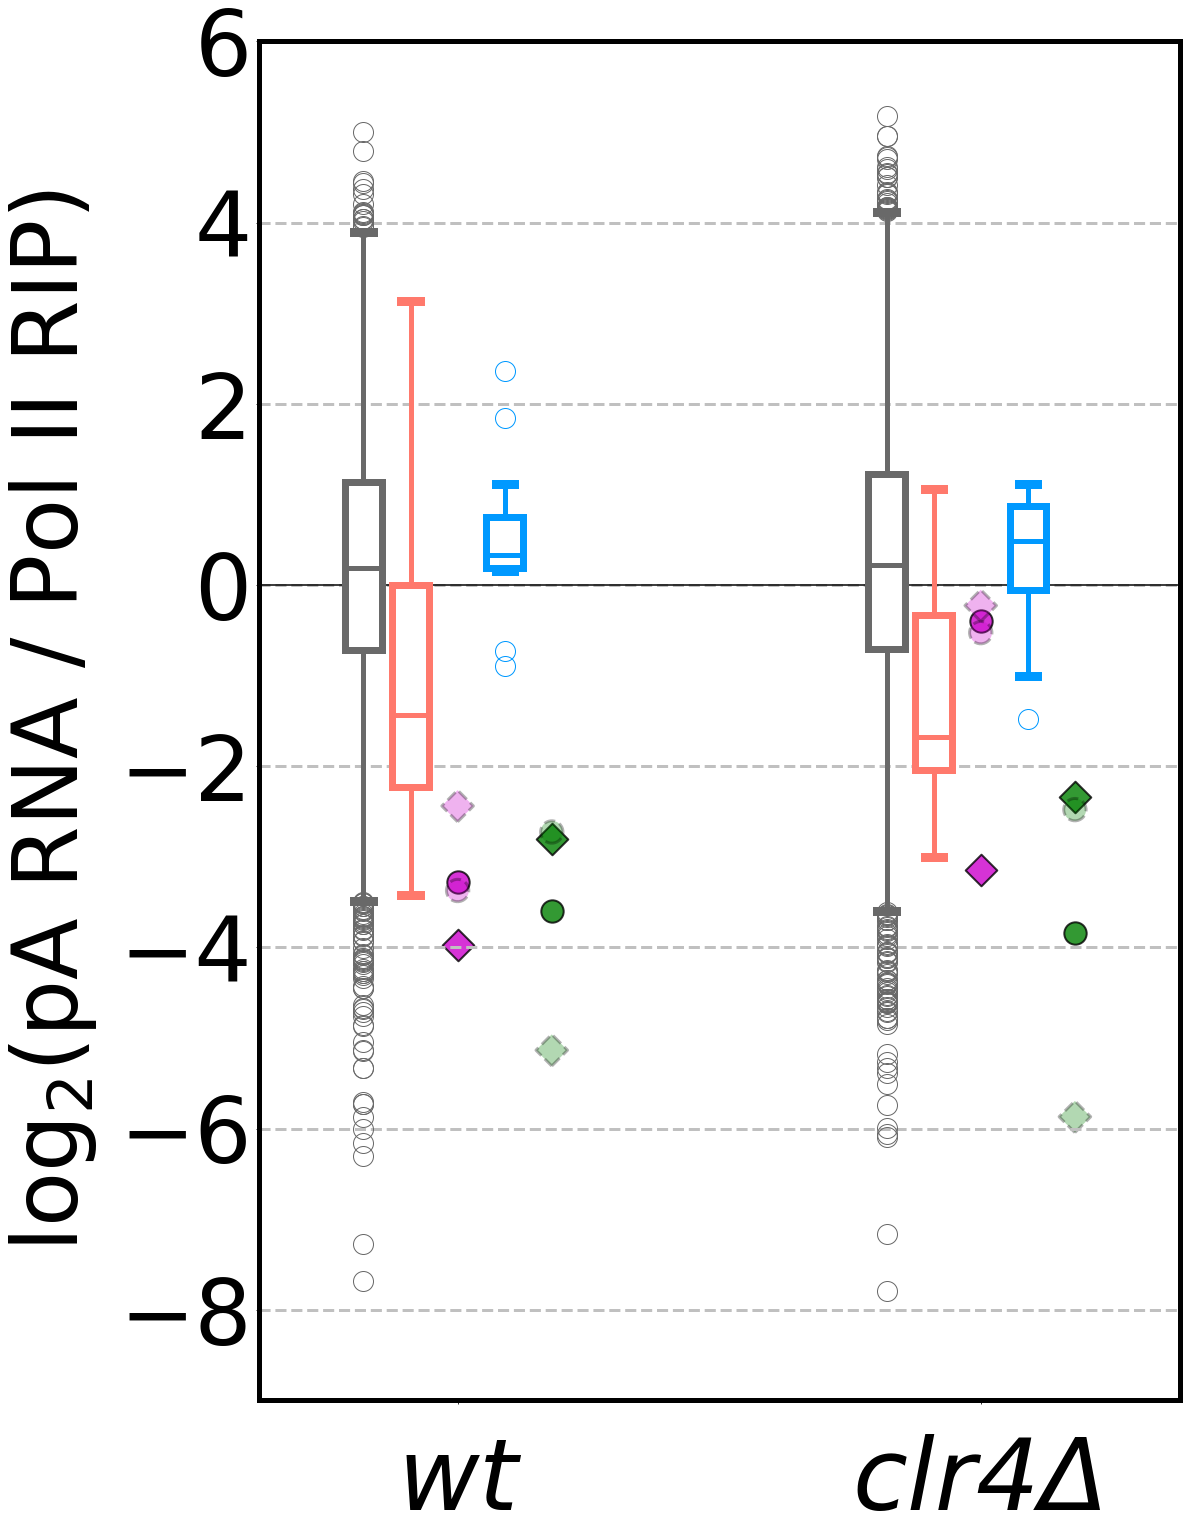

In [27]:
# data and labels
samples = ['WT', '80']
x_labels = ['wt', 'clr4Δ']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure2-C_stranded.png')
#out_path = os.path.join(fig_dir, 'Figure2-C_stranded.png')
out_path = os.path.join(fig_dir, 'Figure2-E_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels,
                    out_path,
                    figsize=(16.5, 25),
                    dist=5, 
                    y_label='$\mathrm{log_2(pA\ RNA\ /\ Pol\ II\ RIP)}$',
                    y_lim=(-9, 6), 
                    widths=.7,
                    hlines=[(0,'black')],
                    xlable_size=100, ylable_size=90,
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

--------------------

## Mutant group 1 - **Figure3-E_stranded**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants.
    - **(E+F)** Box plot showing RNA stability (pA RNA / Pol II RIP) over indicated genes in wild type and mutant cells. Average of at least two independent samples is shown. 


In [28]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-E_stranded.png


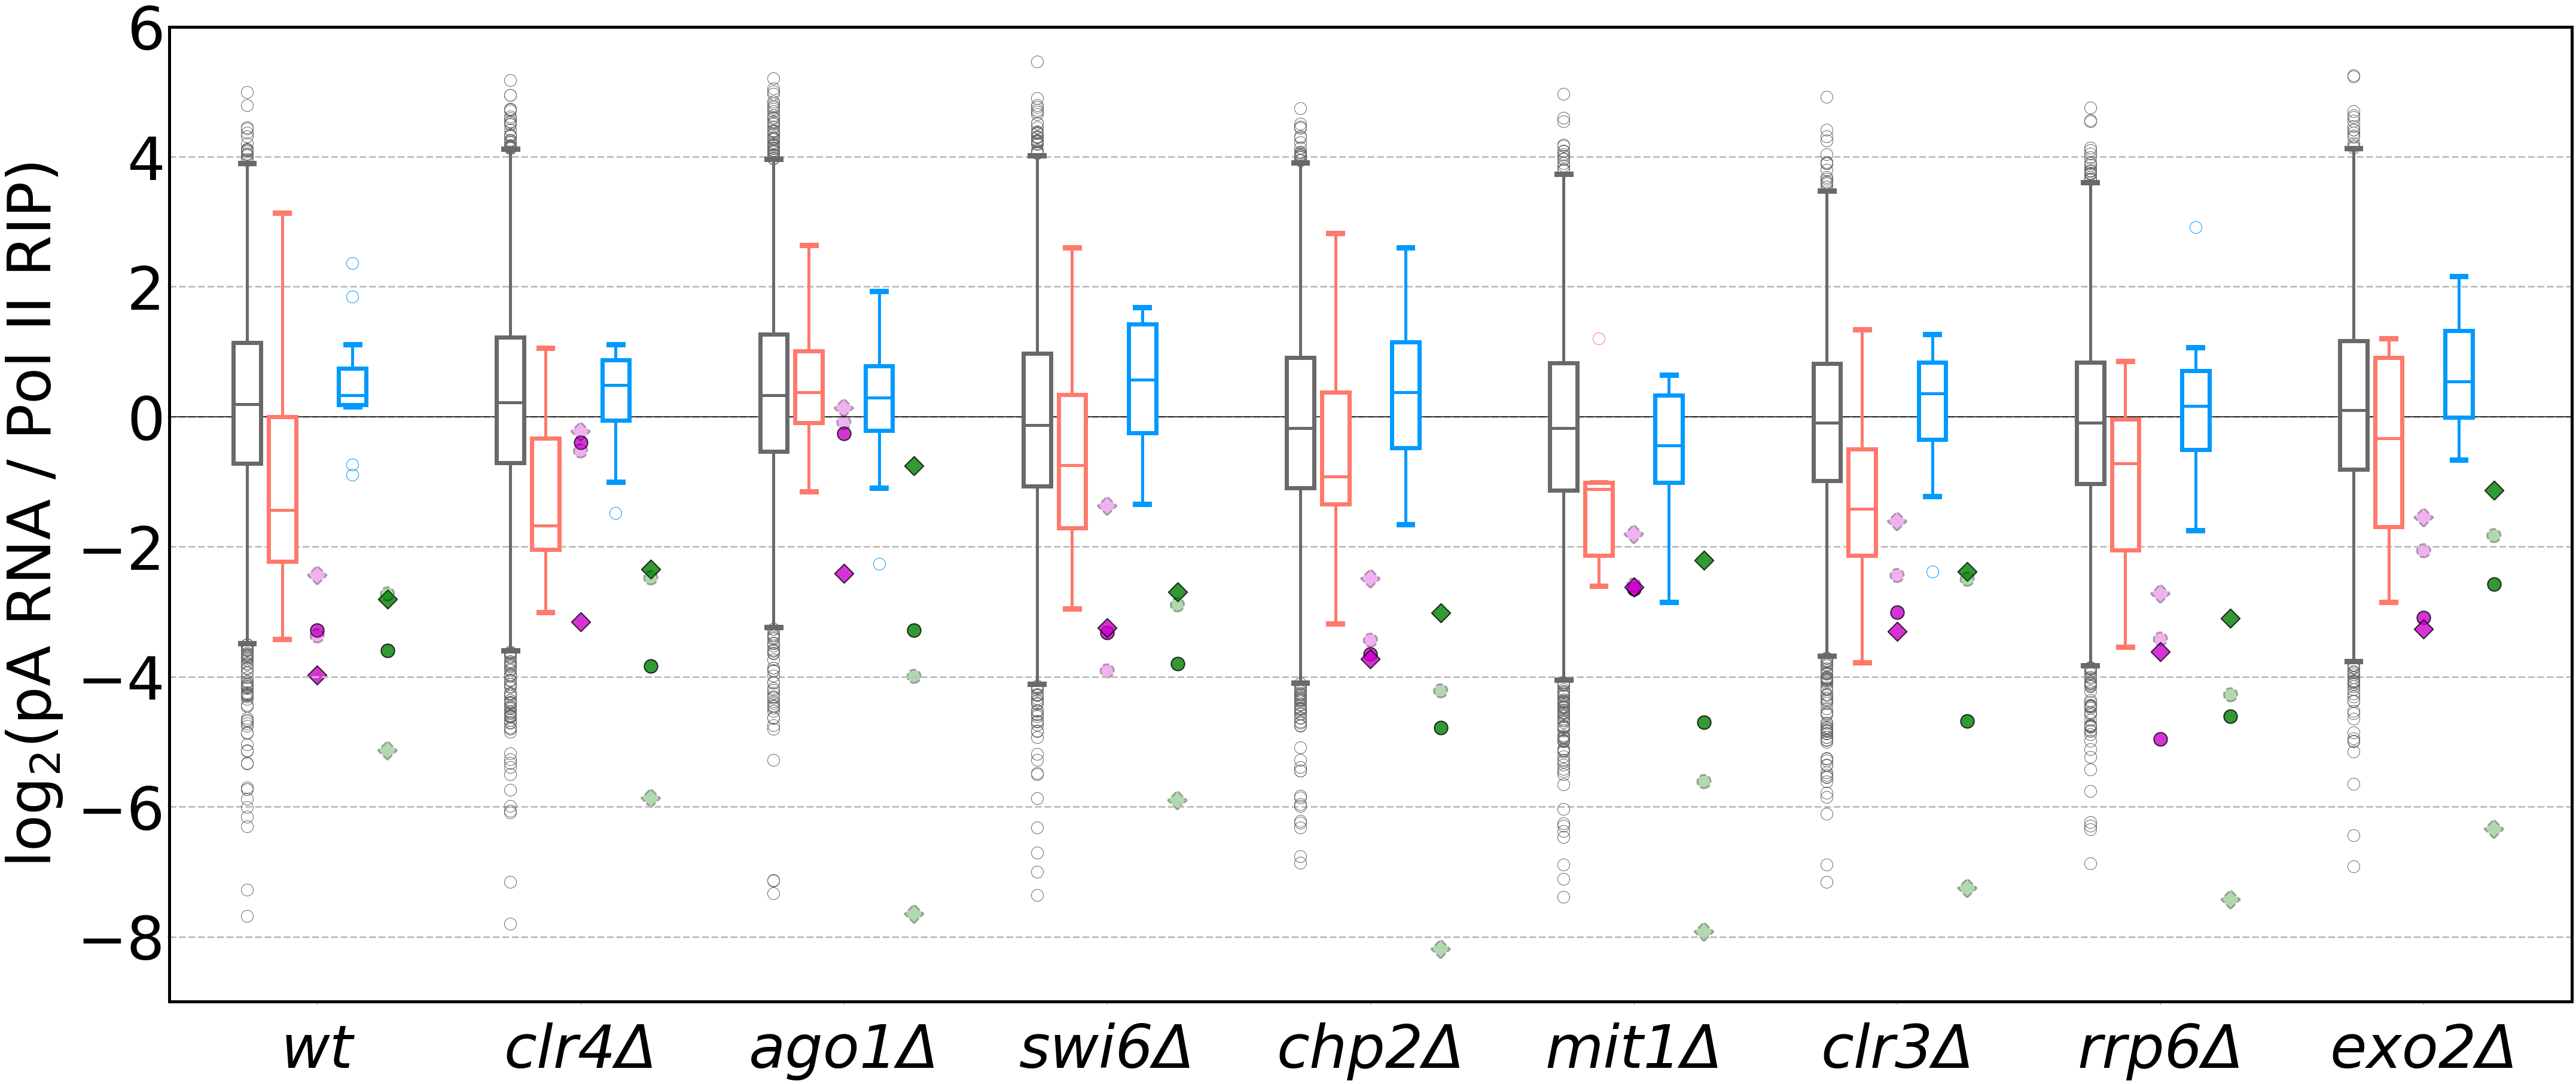

In [29]:
# data and labels
# samples = ['WT', '80', '638', '301', '324', '491', '302']
# x_labels = ['wt', 'clr4Δ', 'ago1Δ', 'swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ']

# data and labels - new version
samples = ['WT', '80', '638', '301', '324', '491', '302', '504', '530']
x_labels = ['wt', 'clr4Δ', 'ago1Δ', 'swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ', 'rrp6Δ', 'exo2Δ']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure3-E_stranded.png')
out_path = os.path.join(fig_dir, 'Figure3-E_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels,
                    out_path,
                    figsize=(len(samples) * 8, 30),
                    #figsize=(56, 30), 
                    dist=6,
                    y_label='$\mathrm{log_2(pA\ RNA\ /\ Pol\ II\ RIP)}$',
                    y_lim=(-9, 6), 
                    hlines=[(0, 'black')],
                    #widths=.8,
                    widths=.7, 
                    xlable_size=100, ylable_size=100, 
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

----

## Mutant group 2 - **Figure3-F_stranded**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants.
    - **(E+F)** Box plot showing RNA stability (pA RNA / Pol II RIP) over indicated genes in wild type and mutant cells. Average of at least two independent samples is shown. 

In [30]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-F_stranded.png


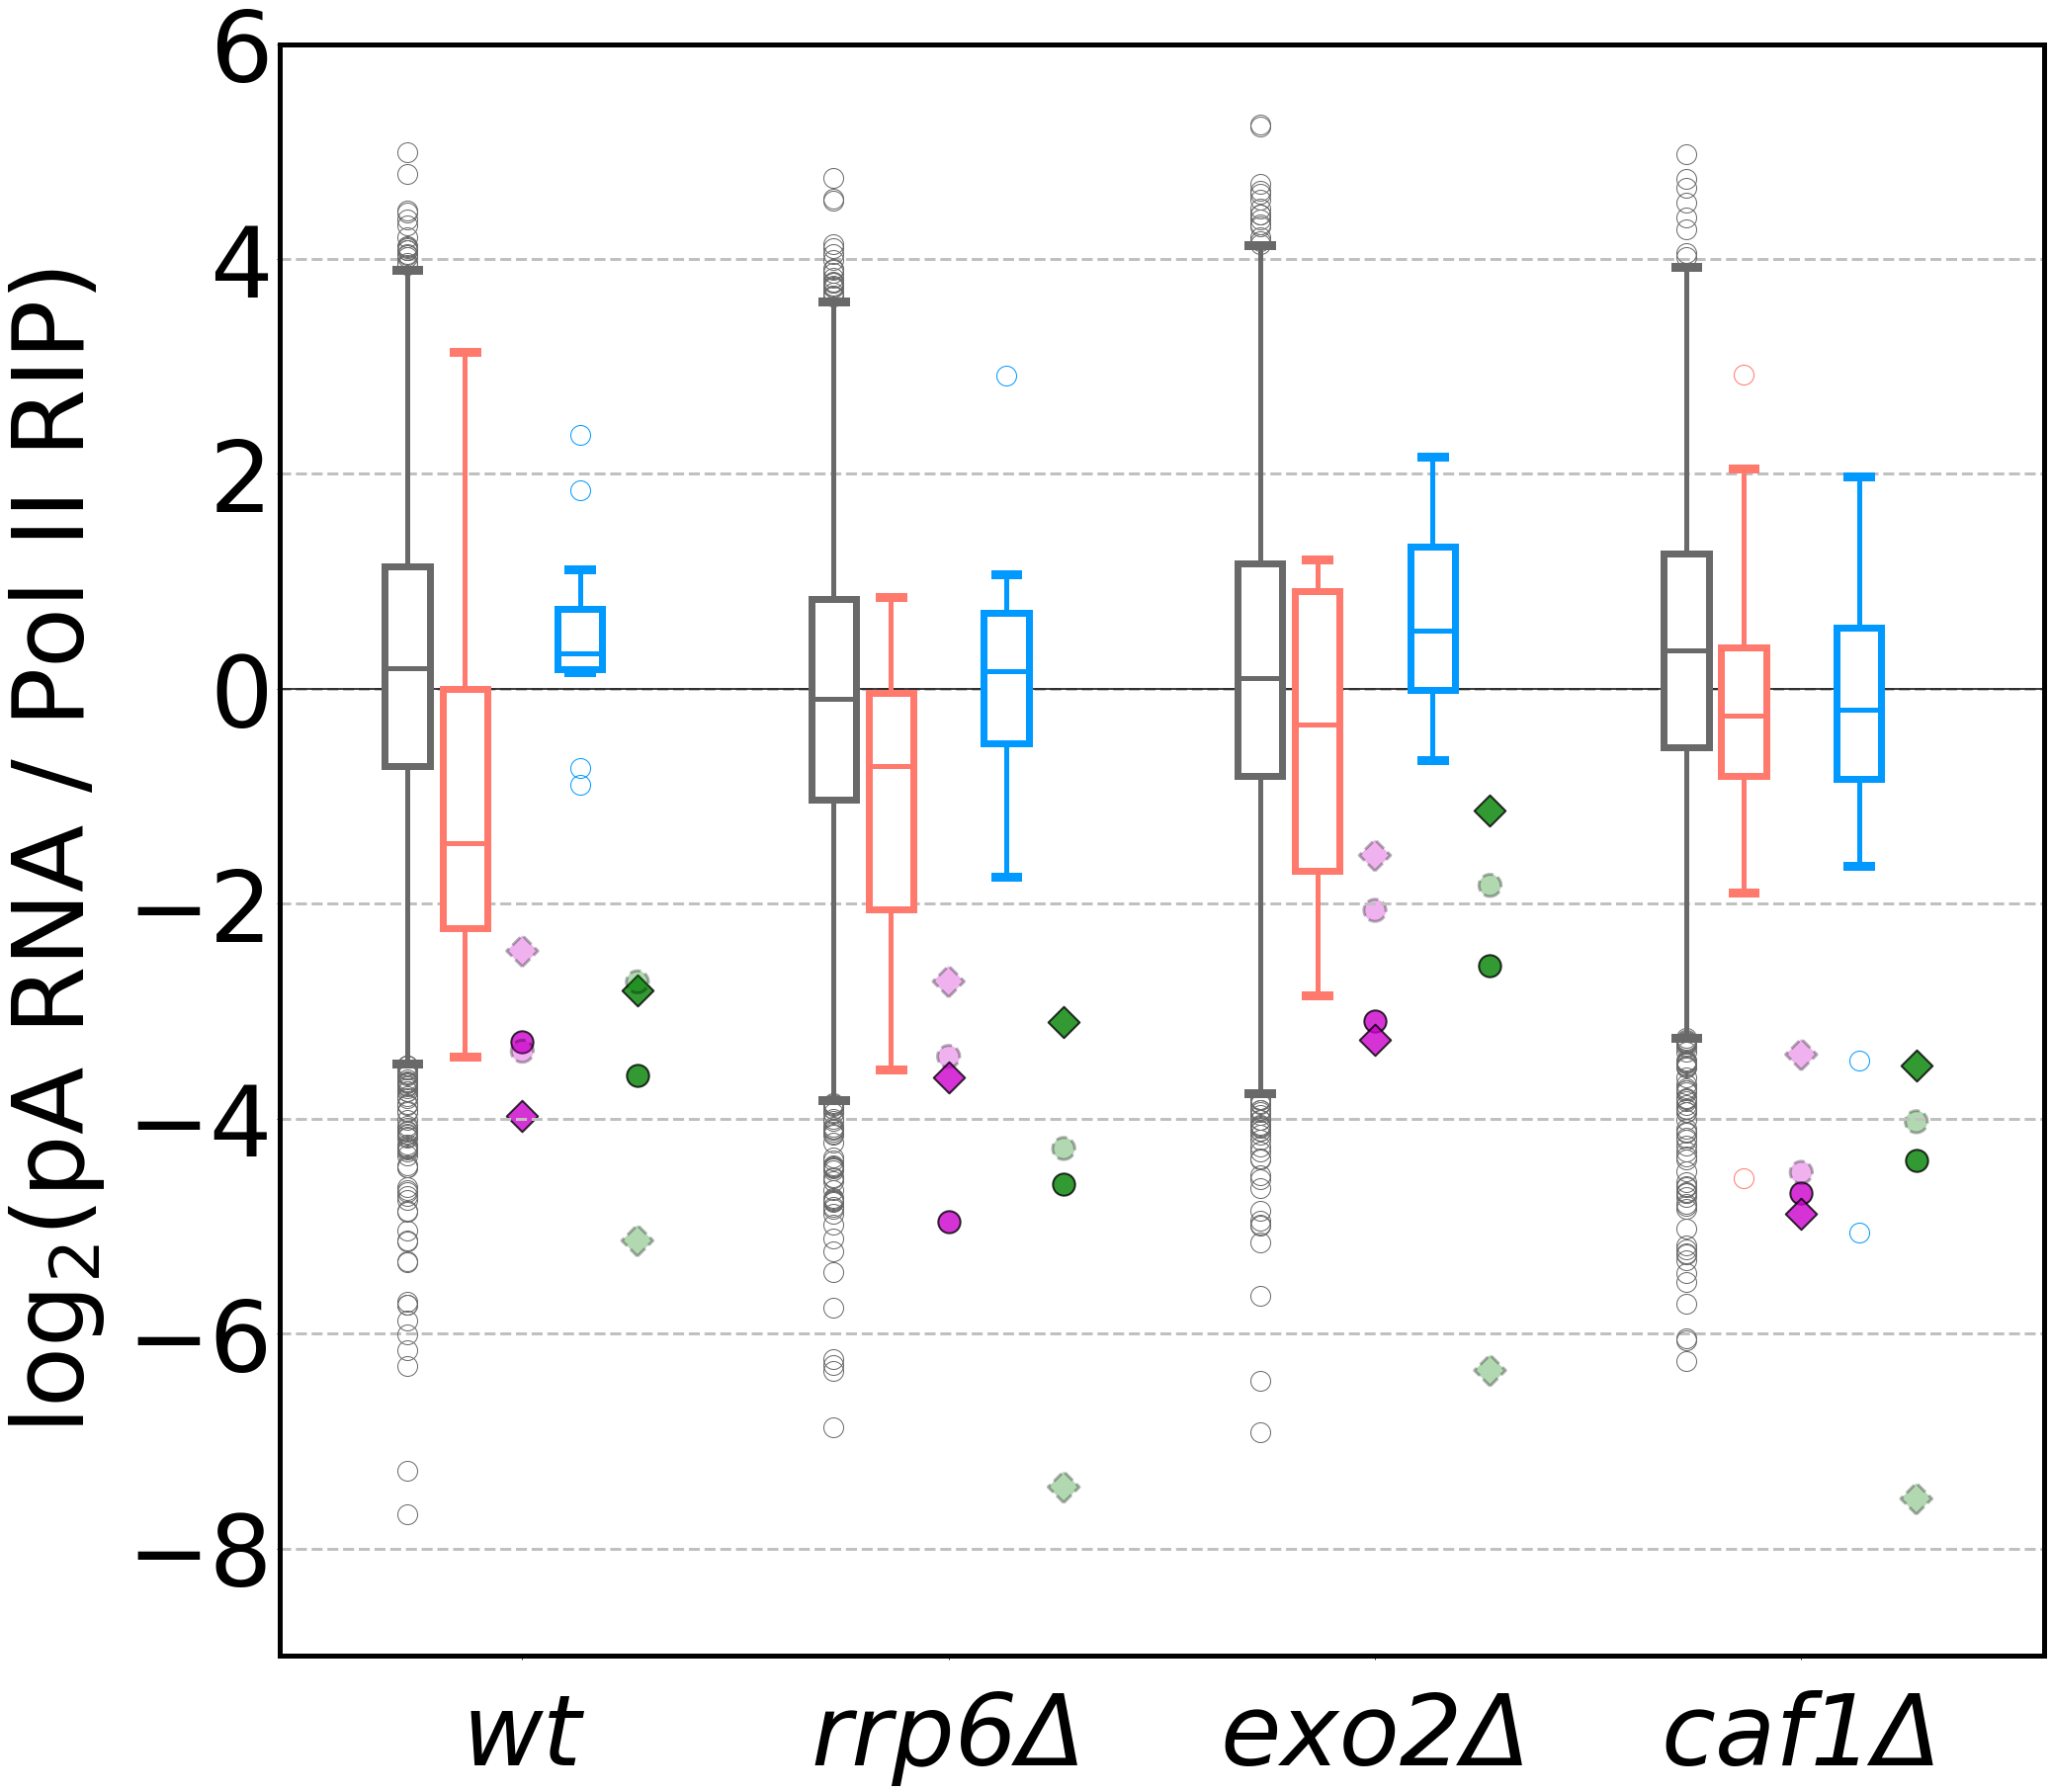

In [31]:
# data and label
samples = ['WT', '504', '530', '510']
x_labels = ['wt', 'rrp6Δ', 'exo2Δ', 'caf1Δ']

#data = prepare_4cat_data(df, samples)

# paths and plot
out_path = os.path.join(plots_dir, 'Figure3-F_stranded.png')
out_path = os.path.join(fig_dir, 'Figure3-F_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels,
                    out_path,
                    figsize=(len(samples) * 8, 30),
                    #figsize=(32, 30), 
                    dist=5,
                    y_label='$\mathrm{log_2(pA\ RNA\ /\ Pol\ II\ RIP)}$',
                    y_lim=(-9, 6), 
                    hlines=[(0, 'black')],
                    #widths=.8,
                    widths=.7,
                    xlable_size=100, ylable_size=100, 
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

----

## Mutant group 3 - **Figure3-F_stranded-extra-ccr4-not-1**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants.
    - **(E+F)** Box plot showing RNA stability (pA RNA / Pol II RIP) over indicated genes in wild type and mutant cells. Average of at least two independent samples is shown. 

In [32]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-F_stranded-extra-ccr4-not-1.png


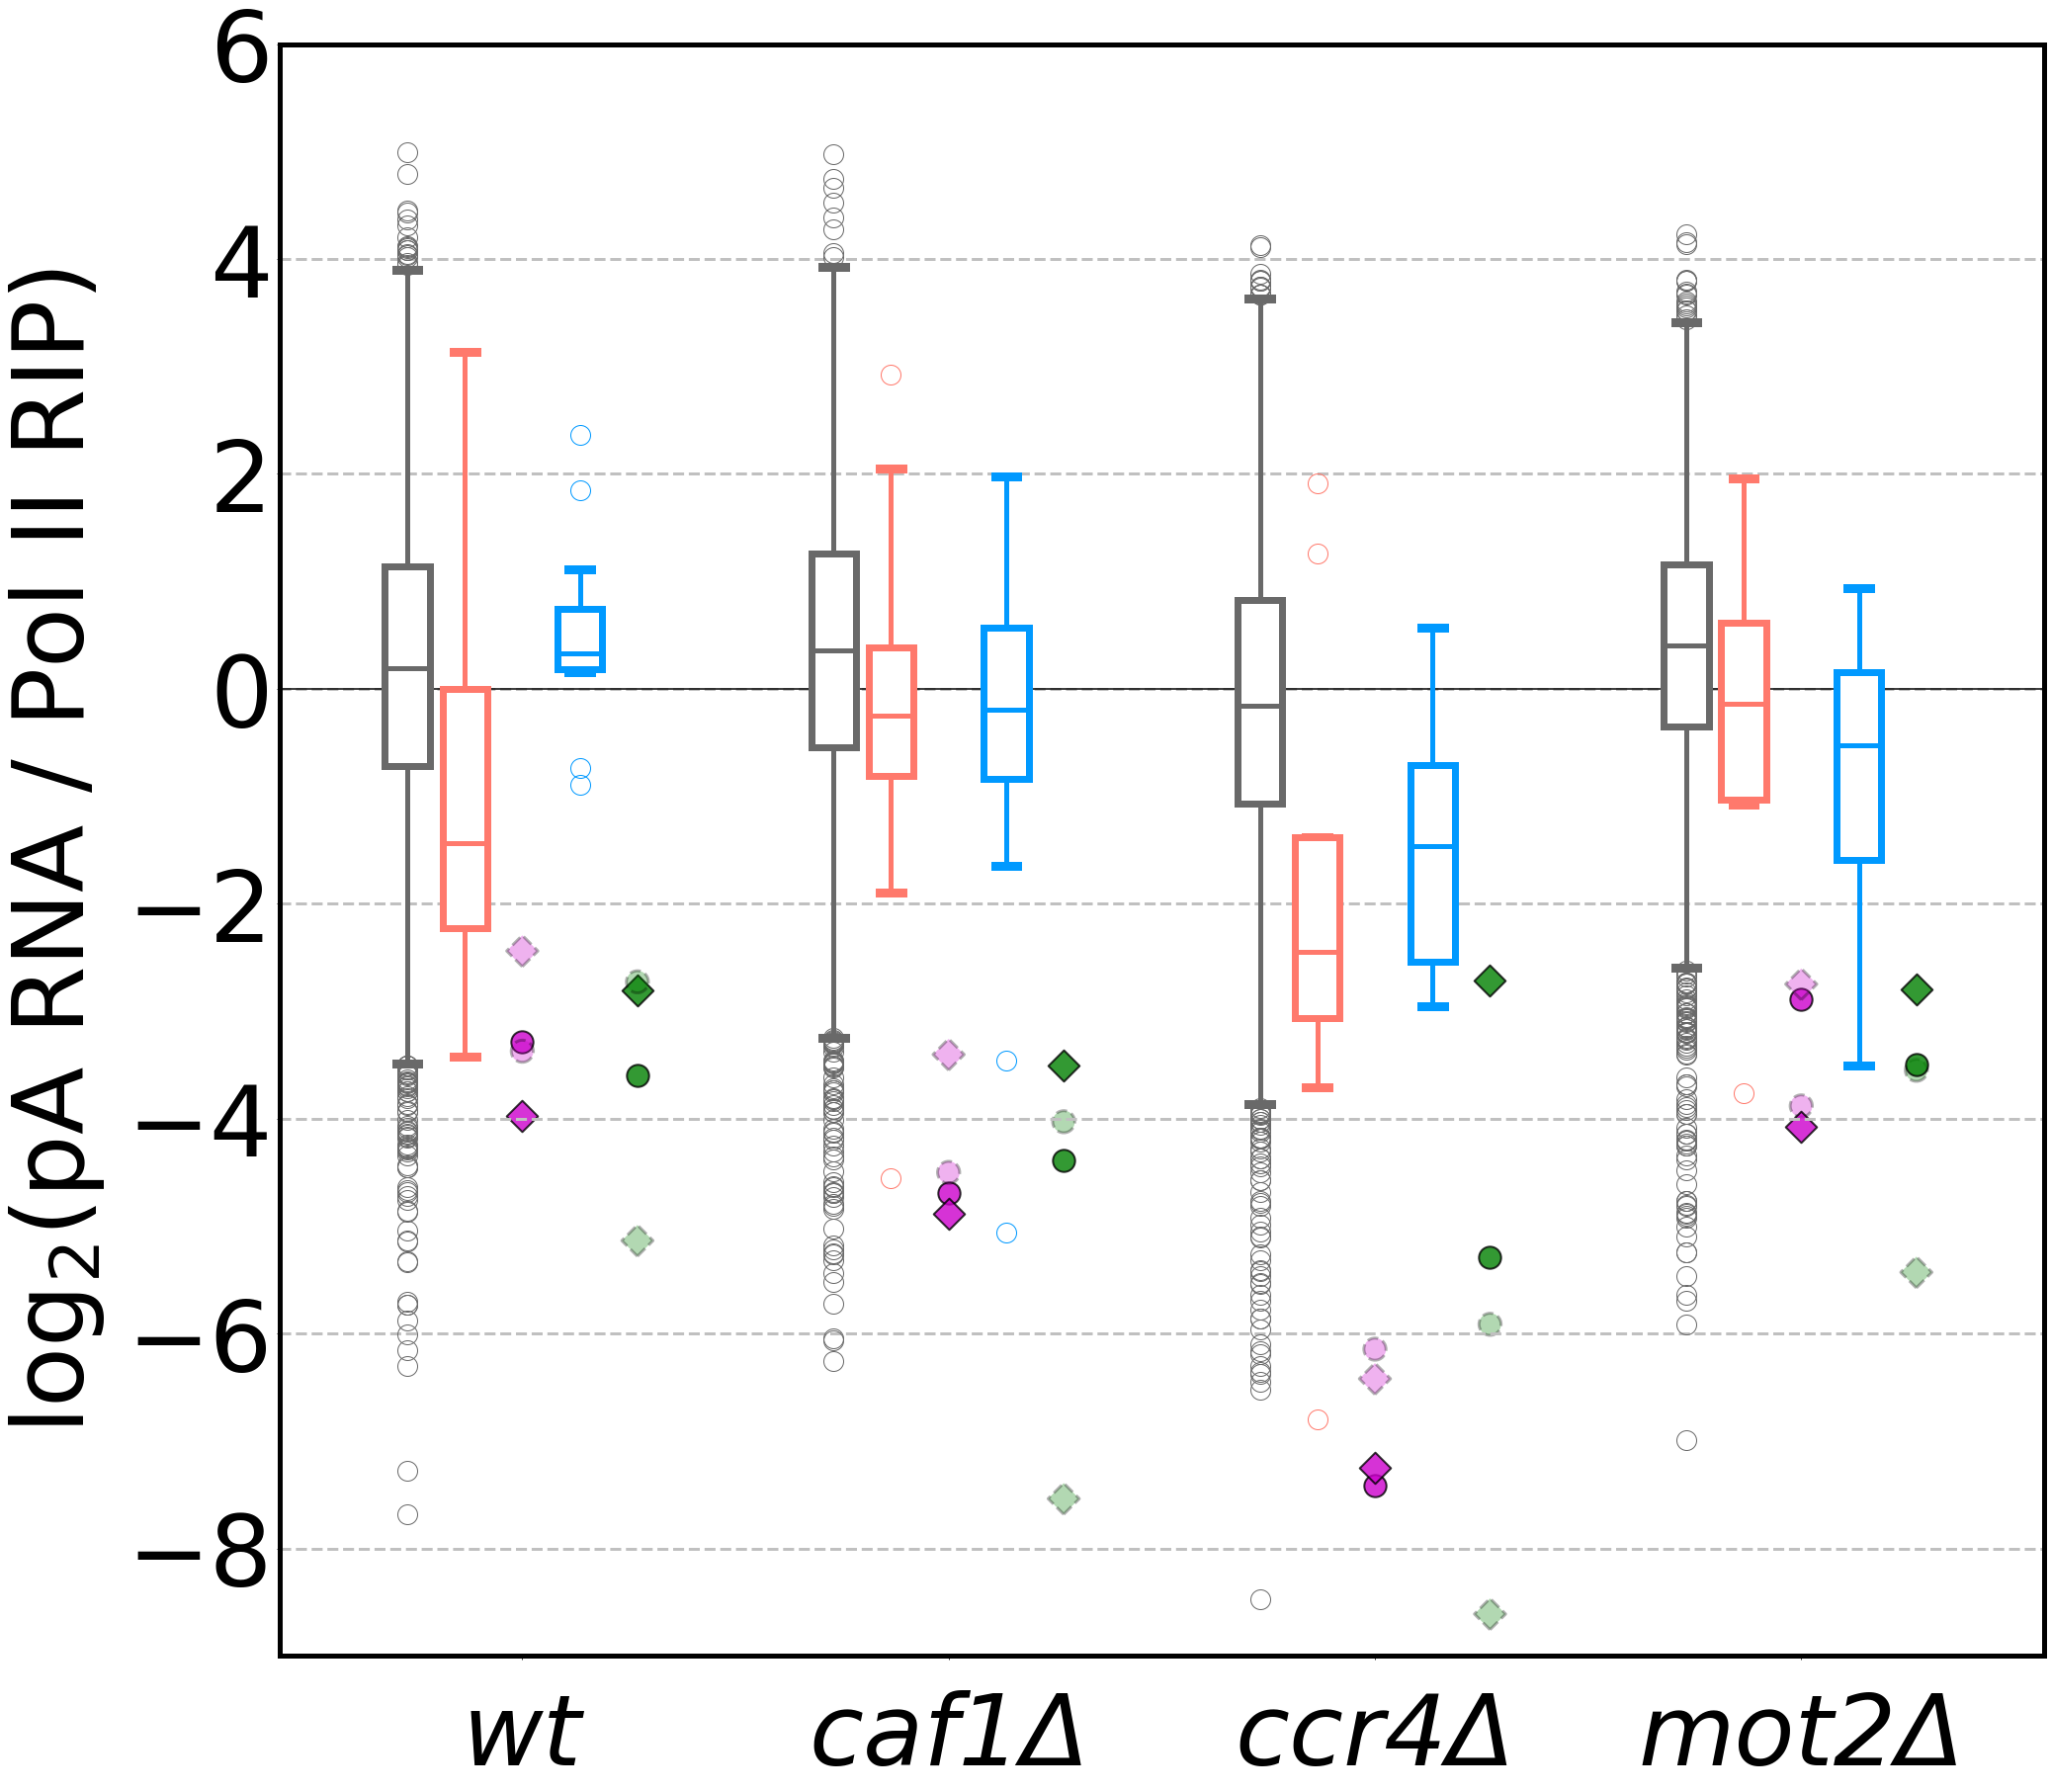

In [33]:
# data and labels
# samples = ['WT', '510', '544', '1022']
# x_labels = ['wt', 'caf1Δ', 'ccr4Δ', 'mot2Δ']

# # data and labels - new version v1
# samples = ['WT', '504', '530', '510', '544', '1022']
# x_labels = ['wt', 'rrp6Δ', 'exo2Δ', 'caf1Δ', 'ccr4Δ', 'mot2Δ']

# data and labels - new version v1
samples = ['WT', '510', '544', '1022']
x_labels = ['wt', 'caf1Δ', 'ccr4Δ', 'mot2Δ']

#data = prepare_4cat_data(df, samples)

# paths and plot
out_path = os.path.join(plots_dir, 'Figure3-F_stranded-extra-ccr4-not-1.png')
out_path = os.path.join(fig_dir, 'Figure3-F_stranded-extra-ccr4-not-1.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels,
                    out_path,
                    figsize=(len(samples) * 8, 30),
                    #figsize=(32, 30), 
                    dist=5,
                    y_label='$\mathrm{log_2(pA\ RNA\ /\ Pol\ II\ RIP)}$',
                    y_lim=(-9, 6), 
                    hlines=[(0, 'black')],
                    #widths=.8,
                    widths=.7, 
                    xlable_size=100, ylable_size=100, 
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

----

## Mutant group 4 - **Figure3-F_stranded-extra-ccr4-not-2**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants.
    - **(E+F)** Box plot showing RNA stability (pA RNA / Pol II RIP) over indicated genes in wild type and mutant cells. Average of at least two independent samples is shown. 

In [34]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-F_stranded-extra-ccr4-not-2.png


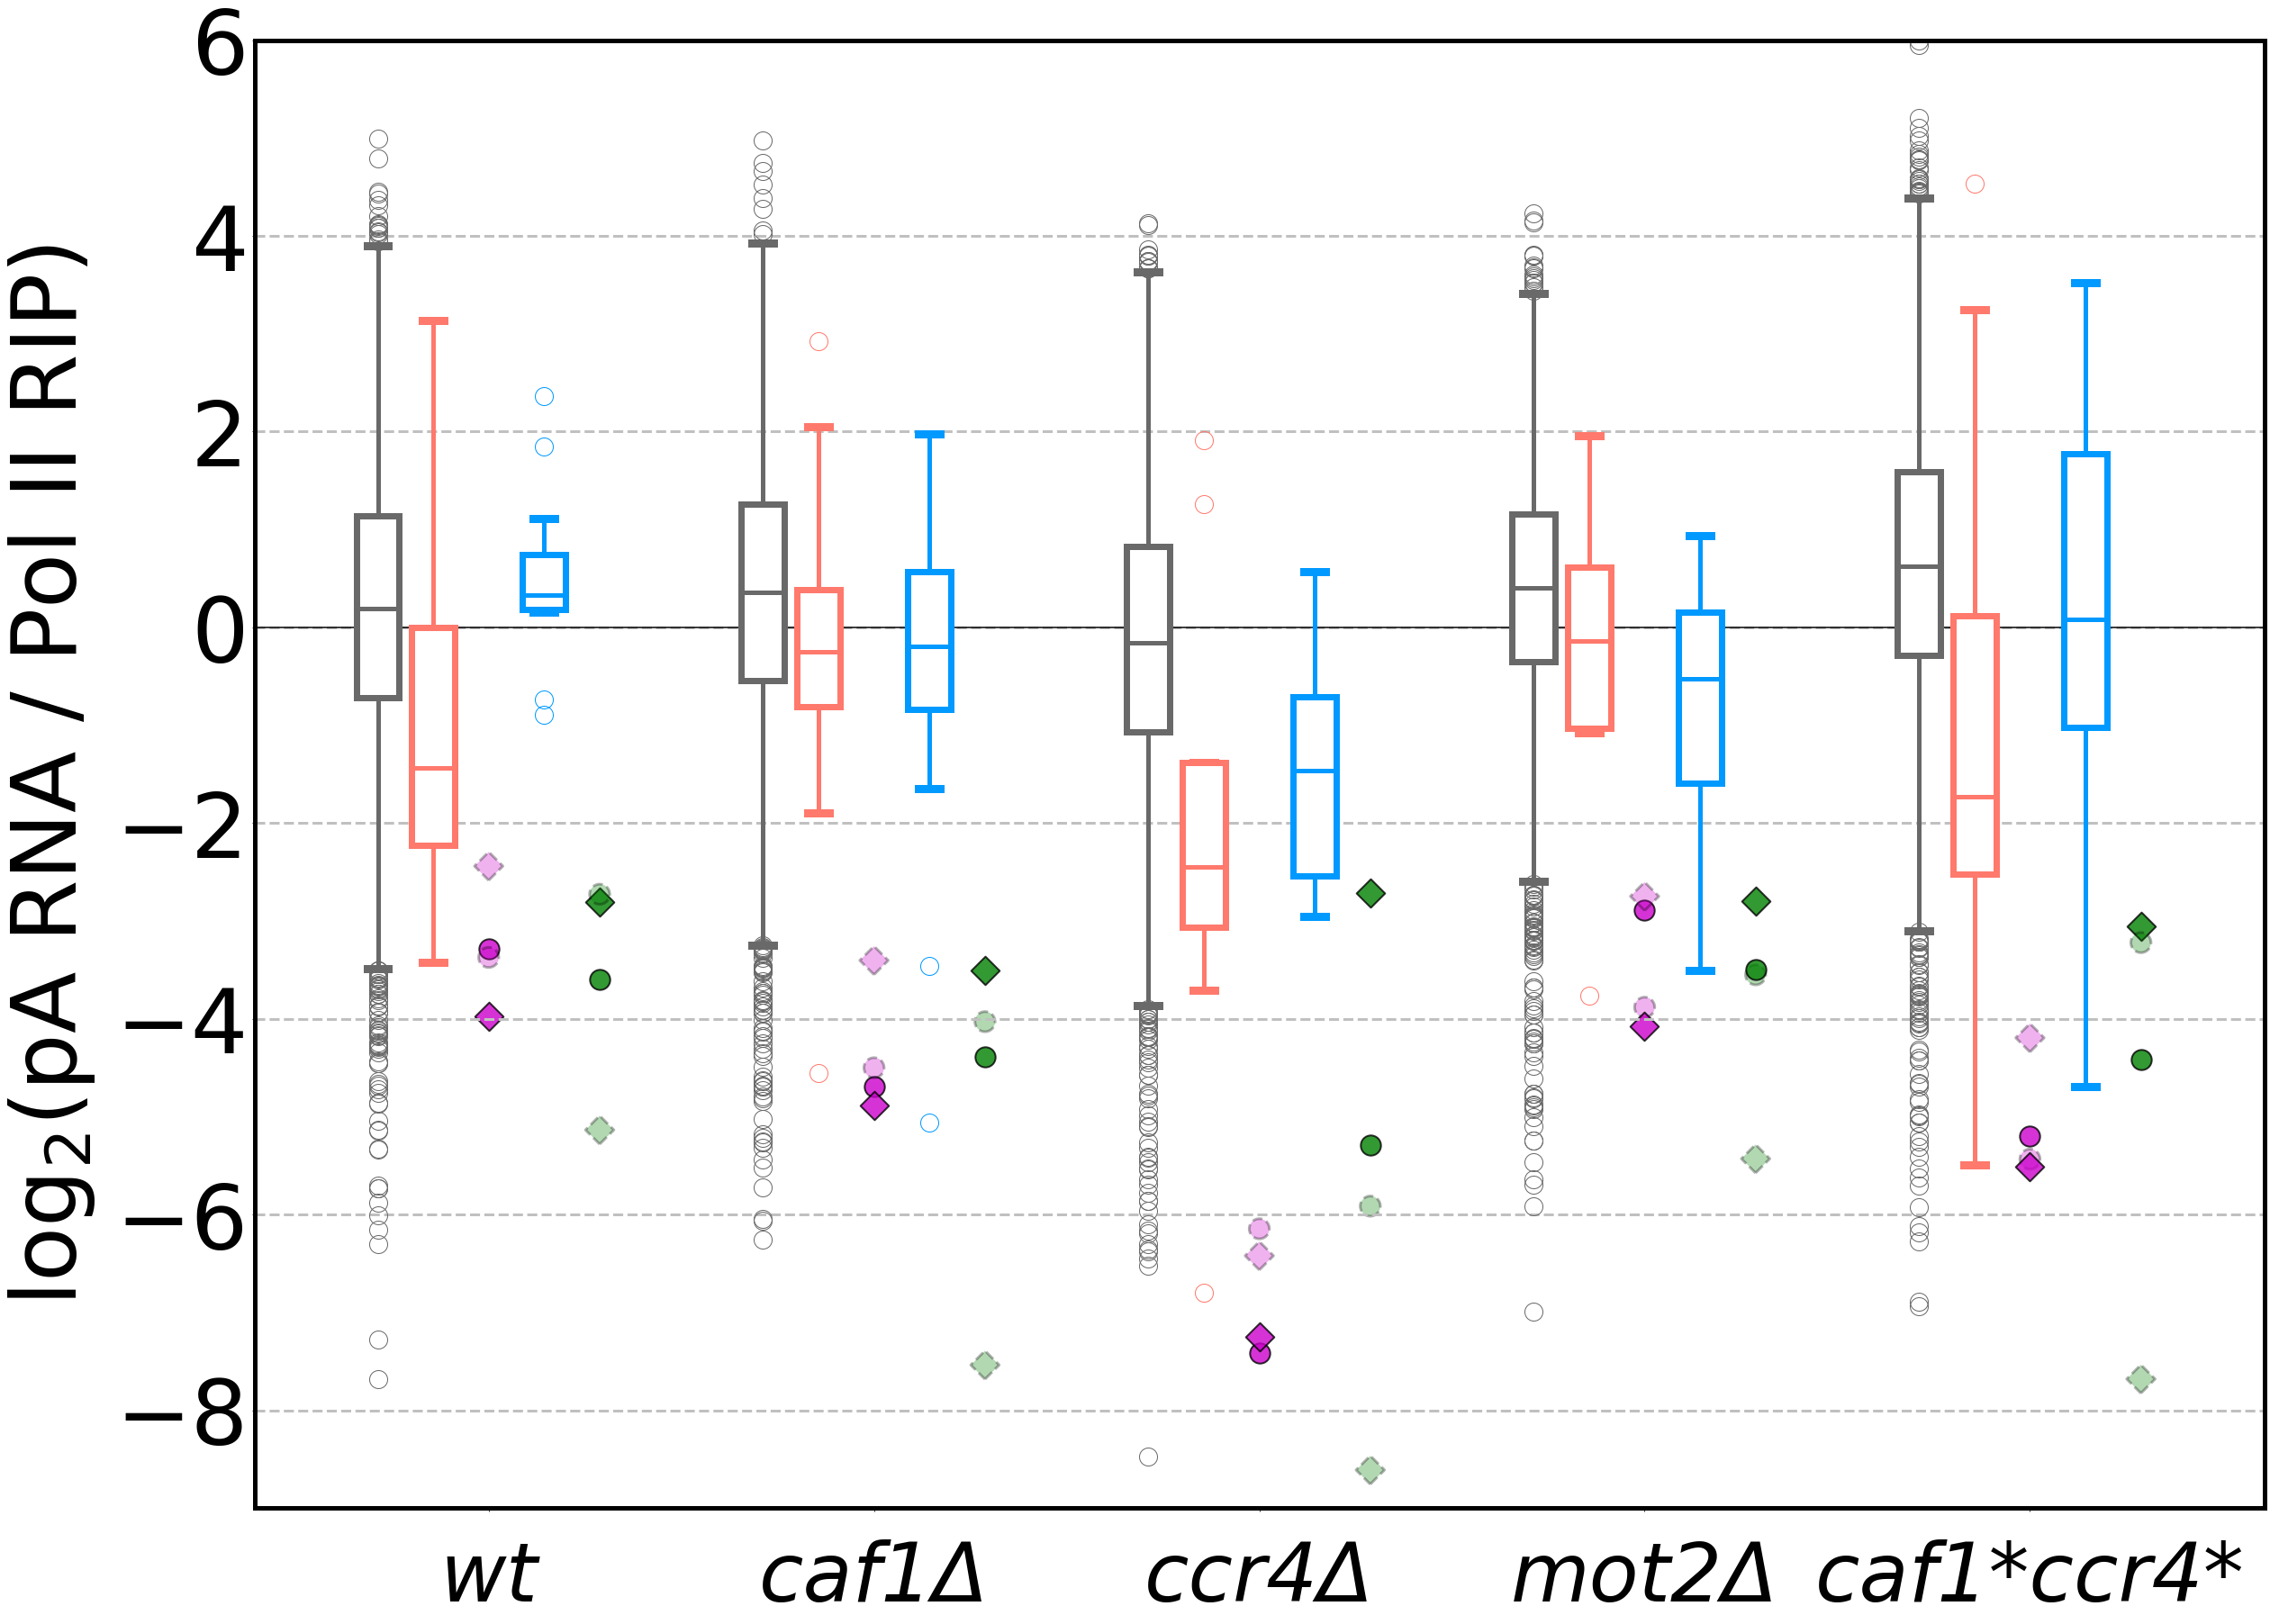

In [35]:
# data and label
samples = ['WT', '510', '544', '1022', '1168']
x_labels = ['wt', 'caf1Δ', 'ccr4Δ', 'mot2Δ', 'caf1*ccr4*']

#data = prepare_4cat_data(df, samples)

# paths and plot
out_path = os.path.join(plots_dir, 'Figure3-F_stranded-extra-ccr4-not-2.png')
out_path = os.path.join(fig_dir, 'Figure3-F_stranded-extra-ccr4-not-2.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels,
                    out_path,
                    figsize=(len(samples) * 8, 30),
                    #figsize=(44, 30), 
                    dist=5,
                    y_label='$\mathrm{log_2(pA\ RNA\ /\ Pol\ II\ RIP)}$',
                    y_lim=(-9, 6), 
                    hlines=[(0, 'black')],
                    #widths=.8,
                    widths=.7, 
                    xlable_size=90, ylable_size=100, 
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)